<a href="https://colab.research.google.com/github/nedokormysh/GB_PyTorch/blob/lesson5/GB_PyTorch_hw_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

# Решение:

In [1]:
! pip install git+https://github.com/qubvel/segmentation_models.pytorch -q
import segmentation_models_pytorch as smp

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 549 kB 35.9 MB/s 
     |████████████████████████████████| 182 kB 77.6 MB/s 


In [3]:
from segmentation_models_pytorch import utils
import numpy as np
import pandas as pd
import os
import torch
import cv2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import albumentations as alb

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Загрузка датасета из каггл.

In [5]:
! mkdir ~/.kaggle
from google.colab import files

files.upload()

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
! kaggle datasets download olekslu/makeup-lips-segmentation-28k-samples

100% 2.37G/2.38G [01:13<00:00, 38.1MB/s]
100% 2.38G/2.38G [01:13<00:00, 34.5MB/s]


In [7]:
! unzip -q '/content/makeup-lips-segmentation-28k-samples.zip'

## Подготовка датасета

In [8]:
DATA_ROOT = '/content/set-lipstick-original'

IMAGE_DATASET_PATH = '/content/set-lipstick-original/720p'
MASK_DATASET_PATH = '/content/set-lipstick-original/mask/'

list_frame = pd.read_csv('/content/set-lipstick-original/list.csv')
list_frame['img_filename'] = DATA_ROOT + '/720p/' + list_frame['filename']
list_frame['mask_filename'] = DATA_ROOT + '/mask/' + list_frame['mask']

list_frame.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask,img_filename,mask_filename
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...


Рассмотрим пример изображения

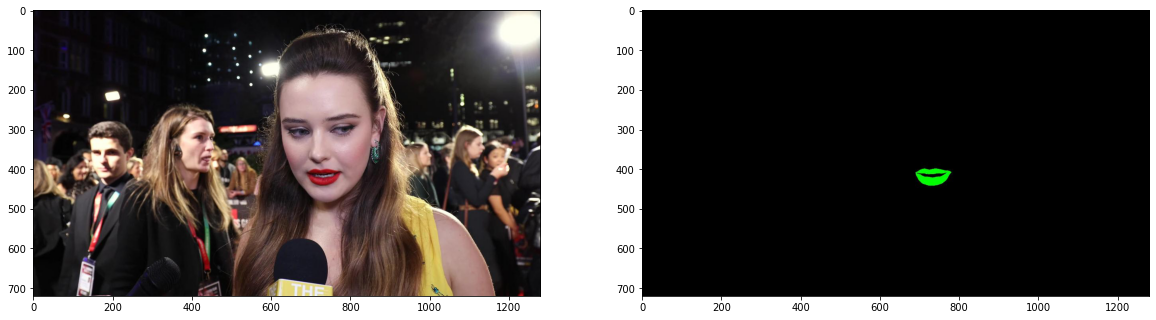

In [108]:
img = plt.imread(IMAGE_DATASET_PATH + '/image00000650.jpg')
# print(img.shape)
mask = plt.imread(MASK_DATASET_PATH + '/mask00000650.png')
# print(mask.shape)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(mask)

Обучение крашится, т.к. количество масок и изображений не совпадает. Поэтому удалим такие строки заранее.

In [22]:
images = []
masks = []
for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            images.append(f)
        elif 'mask' in f:
            masks.append(f)

            
print(f'Количество изображений - {len(images)}.')
print(f'Количество масок - {len(masks)}.')

Количество изображений - 28594.
Количество масок - 28540.


In [26]:
list_frame['have_mask'] = list_frame['mask_filename'].isin(masks)
list_frame['have_mask'].value_counts()

True    28540
Name: have_mask, dtype: int64

In [27]:
list_frame.drop(list_frame.loc[list_frame['have_mask'] == False].index, axis=0, inplace=True)
list_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28540 entries, 0 to 28593
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       28540 non-null  object
 1   width          28540 non-null  int64 
 2   height         28540 non-null  int64 
 3   class          28540 non-null  object
 4   xmin           28540 non-null  int64 
 5   ymin           28540 non-null  int64 
 6   xmax           28540 non-null  int64 
 7   ymax           28540 non-null  int64 
 8   mask           28540 non-null  object
 9   img_filename   28540 non-null  object
 10  mask_filename  28540 non-null  object
 11  flag           28540 non-null  bool  
 12  no_mask        28540 non-null  bool  
 13  have_mask      28540 non-null  bool  
dtypes: bool(3), int64(6), object(5)
memory usage: 3.7+ MB


In [28]:
list_frame['have_mask'].value_counts()

True    28540
Name: have_mask, dtype: int64

Теперь создадим класс датасета для обработки и подготовки данных перед обучением.

In [29]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data['img_filename']
        # и на сегментированные картинки
        self.label_arr = self.data['mask_filename']
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализация
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)    
        mask = cv2.resize(mask, (512, 512))
        mask = np.asarray(mask).astype('float')
        mask = torch.as_tensor(mask) / 255.0  
        mask = mask.permute(2,0,1)
            
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

In [30]:
# создание модели
BACKBONE = 'resnet34'
model = smp.PSPNet(BACKBONE, in_channels=3, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Предобработанное изображение - маска

torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


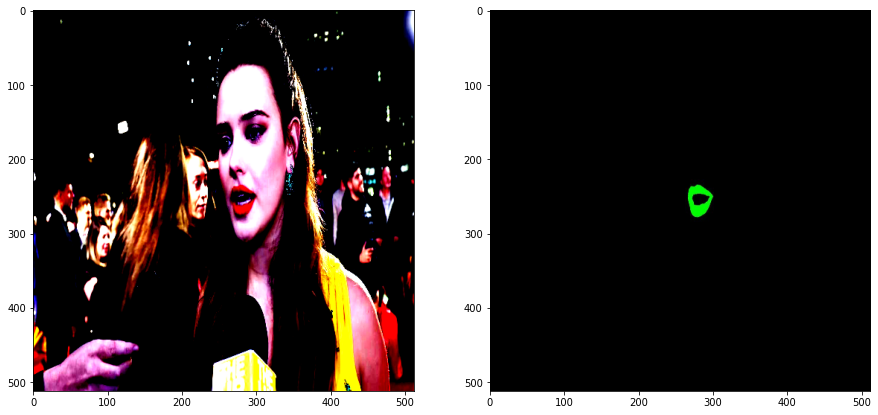

In [31]:
dataset = LipsDataset(list_frame, preprocessing=preprocess_input)
img, mask = dataset[650]
print(img.shape, mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(mask.permute(1, 2, 0))

Разделяем датасет

In [32]:
X_train, X_test = train_test_split(list_frame, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LipsDataset(X_train, preprocessing=preprocess_input)
test_data = LipsDataset(X_test, preprocessing=preprocess_input)

Задаём метрику, лосс, оптимизатор.

In [33]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU()]

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [34]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True,
    num_workers=2,
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

In [35]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

## Обучение модели.

In [36]:
max_score = 0

for i in range(0, 3):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 2141/2141 [04:53<00:00,  7.31it/s, dice_loss - 0.06764, iou_score - 0.8761]
Model saved!
Epoch: 2
valid: 100%|██████████| 2141/2141 [04:50<00:00,  7.37it/s, dice_loss - 0.05215, iou_score - 0.9026]
Model saved!
Epoch: 3
valid: 100%|██████████| 2141/2141 [04:50<00:00,  7.36it/s, dice_loss - 0.05293, iou_score - 0.901]


Результаты работы модели.

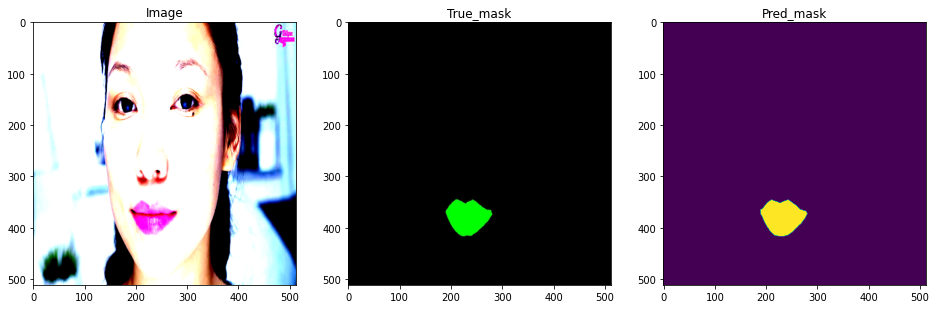

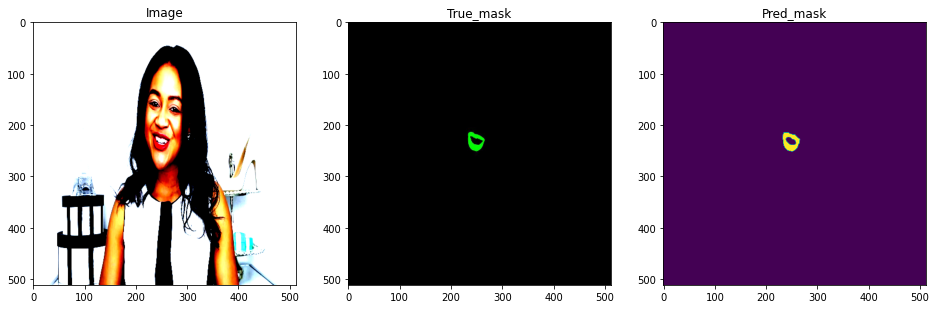

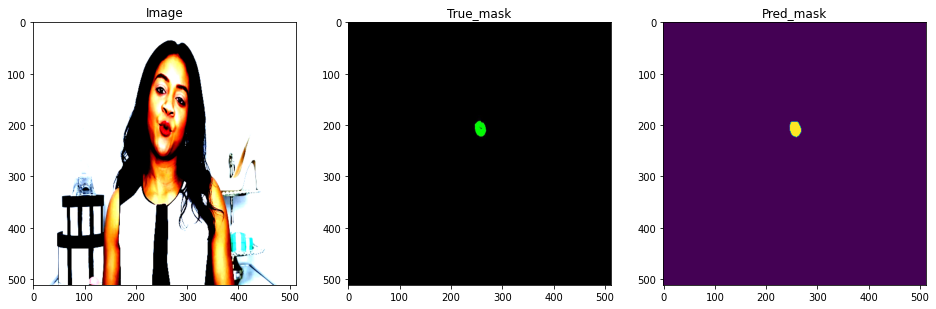

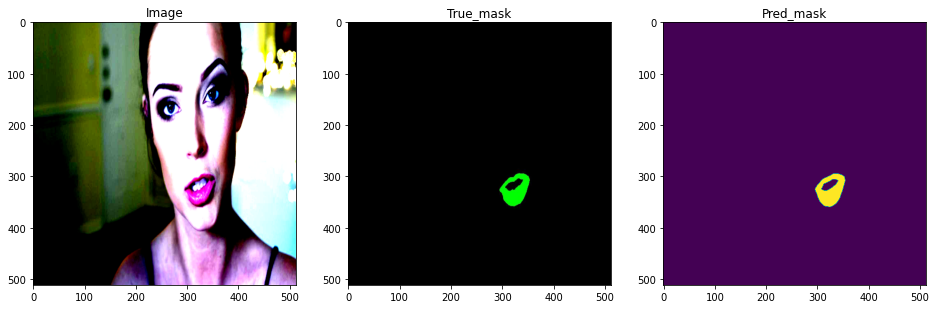

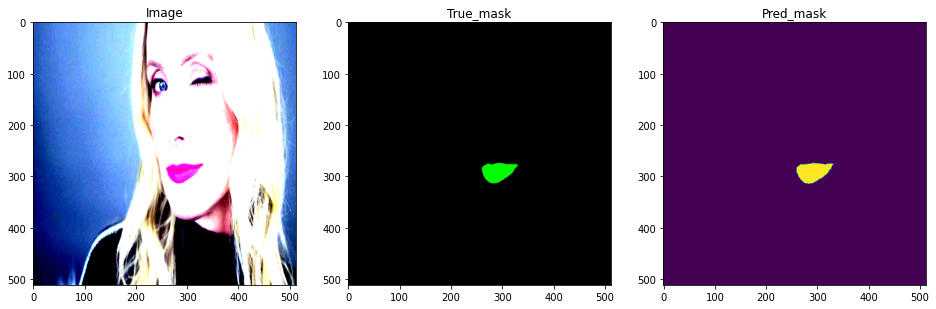

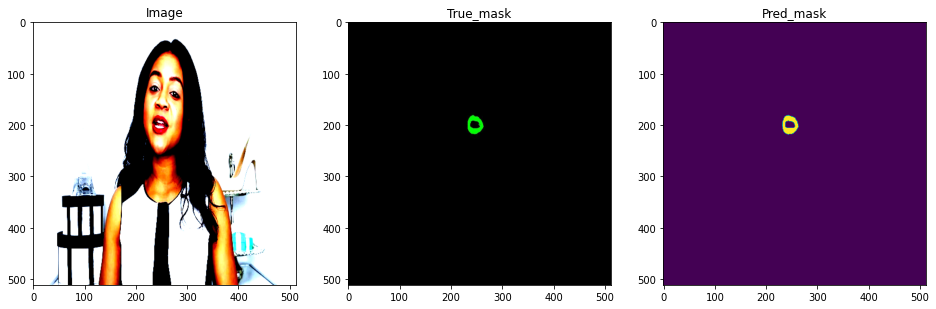

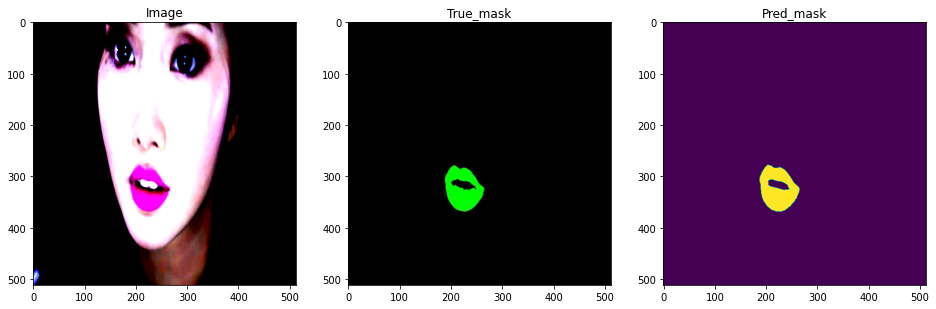

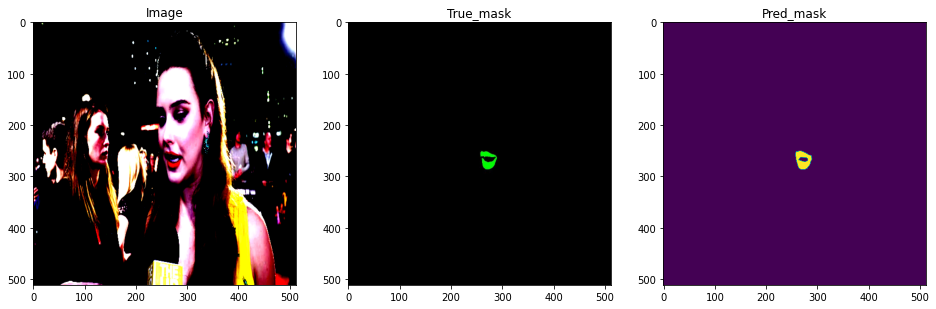

In [147]:
data_iter = iter(train_data_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)

for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')

    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')

    ax_3.imshow(outputs[i].detach().squeeze().cpu())
    ax_3.set_title('Pred_mask')